In [1]:
import os 
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

from collections import defaultdict
import itertools
from typing import Optional

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

from utils.exp_utils import get_conf_dir
from utils.proc_data_utils import get_exp_metrics, get_max_acc, get_acc_results



In [2]:
OUT_DIR = "output/cc_mix_rate_schedule_sweep/final"
CC_RESULTS_DIR = "experiments/250122_cc/results"
RESULTS_DIR = "experiments/250129_mix_rate_schedule/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]
DATASETS = ["toy_grid", "fmnist_mnist", "cifar_mnist", "waterbirds", "celebA-0", "multi-nli"]
METHODS = ["DivDis", "TopK 0.5", "TopK 0.1", "DBAT", "ERM"]
METHODS_TO_LOAD = ["TopK 0.5", "TopK 0.1"]
SEEDS = [1, 2, 3]



In [4]:
def get_results(acc_metric: str, model_selection="val_loss"):
    results = defaultdict(lambda: defaultdict(list))
    for dataset, method in itertools.product(DATASETS, METHODS_TO_LOAD):
        exp_dirs = []
        mix_rates = MIX_RATES if method != "ERM" else [0.0]
        for mix_rate, seed in itertools.product(mix_rates, SEEDS):
            exp_dirs.append(get_conf_dir((dataset, method, mix_rate, seed), OUT_DIR))
        perf_source_acc = dataset == "toy_grid"
        results[dataset][method] = get_acc_results(
            exp_dirs=exp_dirs, acc_metric=acc_metric, model_selection=model_selection, 
            perf_source_acc=perf_source_acc, verbose=True
        )
    # recusrively convert default dict to dict
    return results


In [5]:
def to_df(results: dict[dict]): 
    # Create a list to store flattened data
    flattened_data = []

    # Iterate through the nested structure
    for dataset, method_dict in results.items():
        for method, mix_rate_dict in method_dict.items():
            for mix_rate, accuracies in mix_rate_dict.items():
                # For each accuracy value in the list
                for acc in accuracies:
                    flattened_data.append({
                        'Dataset': dataset,
                        'Method': method,
                        'Mix_Rate': mix_rate,
                        'Accuracy': acc
                    })

    # Create DataFrame
    df = pd.DataFrame(flattened_data)
    df.sort_values(['Dataset', 'Method', 'Mix_Rate'], inplace=True)
    return df 

In [6]:
acc_results = get_results("test_acc", "val_loss")
alt_acc_results = get_results("test_acc_alt", "val_loss")
worst_acc_results = get_results("test_worst_acc", "val_loss")


In [7]:
# mix rate scheudle results
acc_df = to_df(acc_results)
alt_acc_df = to_df(alt_acc_results)
worst_acc_df = to_df(worst_acc_results)
# cc results
cc_acc_df = pd.read_csv(os.path.join(CC_RESULTS_DIR, "acc_results.csv"))
cc_alt_acc_df = pd.read_csv(os.path.join(CC_RESULTS_DIR, "alt_acc_results.csv"))
cc_worst_acc_df = pd.read_csv(os.path.join(CC_RESULTS_DIR, "worst_acc_results.csv"))
# remove topk methods from cc results
cc_acc_df_no_topk = cc_acc_df[~cc_acc_df['Method'].isin(METHODS_TO_LOAD)]
cc_alt_acc_df_no_topk = cc_alt_acc_df[~cc_alt_acc_df['Method'].isin(METHODS_TO_LOAD)]
cc_worst_acc_df_no_topk = cc_worst_acc_df[~cc_worst_acc_df['Method'].isin(METHODS_TO_LOAD)]
# combine dfs 
acc_df = pd.concat([acc_df, cc_acc_df_no_topk])
alt_acc_df = pd.concat([alt_acc_df, cc_alt_acc_df_no_topk])
worst_acc_df = pd.concat([worst_acc_df, cc_worst_acc_df_no_topk])


In [8]:
acc_df.to_csv(os.path.join(RESULTS_DIR, "acc_results.csv"), index=False)
alt_acc_df.to_csv(os.path.join(RESULTS_DIR, "alt_acc_results.csv"), index=False)
worst_acc_df.to_csv(os.path.join(RESULTS_DIR, "worst_acc_results.csv"), index=False)

In [9]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10

# use standard matplotlib colors
color_map = plt.rcParams['axes.prop_cycle'].by_key()['color']
METHOD_COLORS = {
    "TopK 0.1": color_map[0], 
    "DivDis": color_map[1],
    "TopK 0.5": color_map[2], 
    "DBAT": color_map[3], 
    "ERM": color_map[4], 
}

DATASET_TITLES = {
    "toy_grid": "Toy Grid",
    "fmnist_mnist": "FMNIST+MNIST",
    "cifar_mnist": "CIFAR+MNIST",
    "waterbirds": "Waterbirds",
    "celebA-0": "CelebA",
    "multi-nli": "MultiNLI"
}

# Accuracies Across Mix Rates

In [10]:
def plot_acc_results_grid(
    df: pd.DataFrame,
    nrows: int = 2,
    ncols: int = 3,
    figsize: tuple[float, float] = (6, 4),
    ylim: tuple[float, float] = (0.5, 1.0),
    fontsize: int = 10,
    tick_fontsize: int = 8,
    legend_fontsize: int = 8,
    xlabel: str = "Mix Rate",
    ylabel: str = "Accuracy",
    dataset_titles: dict[str, str] = {},
    datasets: list[str] = DATASETS, 
    methods: list[str] = METHODS, 
    legend_bbox: tuple[float, float] = (0.5, 1.05), 
    method_linestyle: dict[str, str] = {},
    method_colors: dict[str, str] = METHOD_COLORS,
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, dataset in enumerate(datasets):  # Using global DATASETS
        ax = axes[idx]
        dataset_data = df[df['Dataset'] == dataset]
        
        for method in methods:  # Using global METHODS
            method_data = dataset_data[dataset_data['Method'] == method]
            
            if method == "ERM":
                # For ERM, calculate mean and std of all results
                mean_acc = method_data['Accuracy'].mean()
                std_acc = method_data['Accuracy'].std()
                means = [mean_acc] * len(MIX_RATES)
                stds = [std_acc] * len(MIX_RATES)
                line_style = '--'
                marker = None
            else:
                # For other methods, group by mix rate
                grouped = method_data.groupby('Mix_Rate')['Accuracy']
                means = []
                stds = []
                for rate in MIX_RATES: 
                    rate_data = grouped.get_group(rate)
                    means.append(rate_data.mean())
                    stds.append(rate_data.std())
                line_style = method_linestyle.get(method, '-')
                marker = 'o'
            
            ax.plot(MIX_RATES, means, label=method, marker=marker, linestyle=line_style, color=method_colors[method])
            ax.fill_between(MIX_RATES, 
                          [m - s for m, s in zip(means, stds)],
                          [m + s for m, s in zip(means, stds)],
                          alpha=0.2, 
                          color=method_colors[method])

        x_labels = [str(mix_rate) for mix_rate in MIX_RATES]
        ax.set_xticks(MIX_RATES)
        ax.set_xticklabels(x_labels, fontsize=tick_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        title = dataset_titles.get(dataset, dataset) if dataset_titles else dataset
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylim(*ylim)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a single legend for the entire figure
    handles, labels = axes[0].get_lines(), [line.get_label() for line in axes[0].get_lines()]
    fig.legend(handles, labels, loc='center', bbox_to_anchor=legend_bbox, ncol=len(methods), fontsize=fontsize)

    fig.supxlabel(xlabel, fontsize=fontsize)
    fig.supylabel(ylabel, fontsize=fontsize)
    
    fig.tight_layout()
    return fig, axes

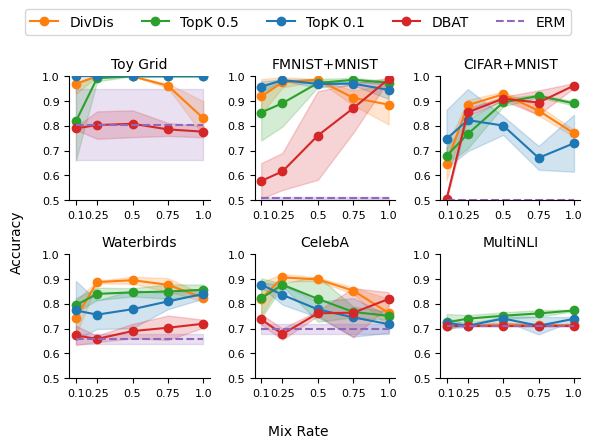

In [11]:
fig, axes = plot_acc_results_grid(
    acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_acc.svg", bbox_inches="tight", dpi=300)
plt.show()

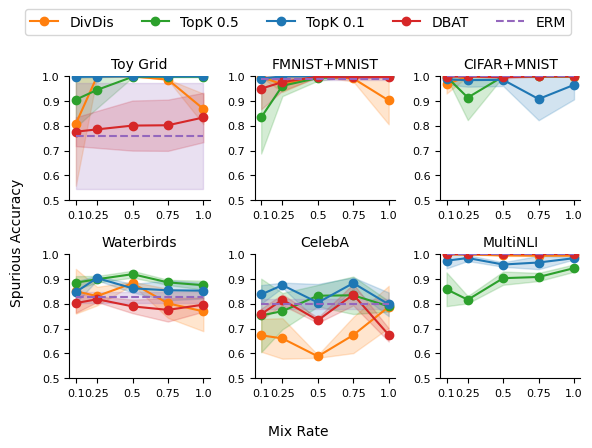

In [12]:
fig, axes = plot_acc_results_grid(
    alt_acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Spurious Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_alt.svg", bbox_inches="tight", dpi=300)
plt.show()

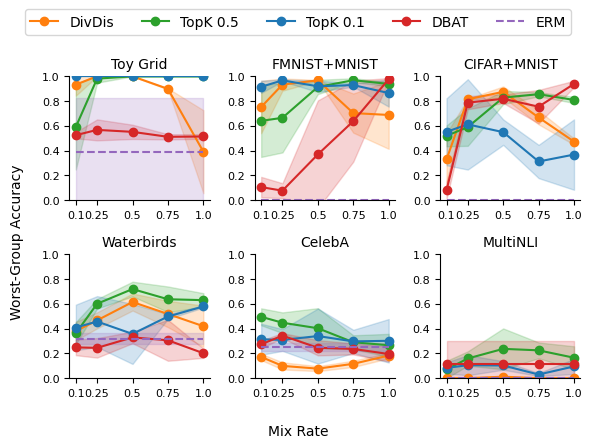

In [13]:
fig, axes = plot_acc_results_grid(
    worst_acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Worst-Group Accuracy", 
    ylim=(0.0, 1.0), 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05))
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_worst.svg", bbox_inches="tight", dpi=300,)
plt.show()

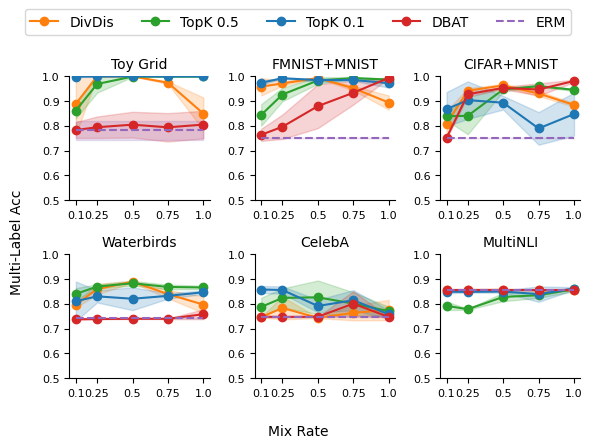

In [14]:
# create new dataframe averaging acc and alt acc
# Create average accuracy dataframe by combining acc_df and alt_acc_df
avg_acc_df = pd.DataFrame()
avg_acc_df['Dataset'] = acc_df['Dataset']
avg_acc_df['Method'] = acc_df['Method']
avg_acc_df['Mix_Rate'] = acc_df['Mix_Rate']
avg_acc_df['Accuracy'] = (acc_df['Accuracy'] + alt_acc_df['Accuracy']) / 2

# Save the averaged results
avg_acc_df.to_csv(os.path.join(RESULTS_DIR, "avg_acc_results.csv"), index=False)

# Plot the averaged results
fig, axes = plot_acc_results_grid(avg_acc_df, dataset_titles=DATASET_TITLES, ylabel="Multi-Label Acc")
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_multi_label.svg", bbox_inches="tight", dpi=300)
plt.show()


# Aggregate Metrics Across Datasets

In [23]:
from matplotlib.patches import Patch

In [63]:
def plot_aggregate_metrics(
    df: pd.DataFrame,
    included_methods: list[str] = [],
    figsize: tuple[float, float] = (6, 3),
    save_path: Optional[str] = None,
    metric_col: str = 'Accuracy',
    ylim: tuple[float, float] = (-0.1, 1.0), 
    width: float = 0.75,  # Made width a parameter with a smaller default
    title: Optional[str] = None, 
    ylabel: Optional[str] = None, 
    legend_bbox: tuple[float, float] = (0.5, 1), 
    method_colors: dict[str, str] = METHOD_COLORS,
):
    # Get ERM baseline for each dataset
    erm_baselines = df[df['Method'] == 'ERM'].groupby('Dataset')[metric_col].mean()
    
    # Filter for included methods and calculate differences from ERM baseline
    method_df = df[df['Method'].isin(included_methods)].copy()
    method_df['Accuracy_Diff'] = method_df.apply(
        lambda row: row[metric_col] - erm_baselines.get(row['Dataset'], 0), 
        axis=1
    )

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set y-limits
    ax.set_ylim(ylim)

    # Calculate positions for box plots
    mix_rates = sorted(method_df['Mix_Rate'].unique())
    x = np.arange(len(mix_rates))
    x = x * (len(included_methods) + 1)  # Increase spacing between mix rate groups
    
    # Plot boxes for each method
    box_positions = []
    box_data = []
    labels = []
    colors = []
    
    for i, method in enumerate(included_methods):
        for j, mix_rate in enumerate(mix_rates):
            data = method_df[(method_df['Method'] == method) & 
                           (method_df['Mix_Rate'] == mix_rate)]['Accuracy_Diff']
            if len(data) > 0:
                pos = x[j] + width * (i - len(included_methods)/2 + 0.5)
                box_positions.append(pos)
                box_data.append(data)
                labels.append(method)
                colors.append(method_colors[method])

    # Create box plot
    boxes = ax.boxplot(box_data, positions=box_positions, patch_artist=True,
                      medianprops=dict(color='black'),
                      whiskerprops=dict(linestyle='--', color='black'),
                      flierprops=dict(marker='o', markerfacecolor='gray', markersize=4),
                      widths=width)  # Set box width
    
    # Color the boxes according to method
    for box, color in zip(boxes['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    
    if ylabel is None: 
        ylabel = 'Accuracy Difference from ERM'
    ax.set_title(title)
    
    # Update x-axis ticks to be centered for each mix rate group
    # tick_positions = [x[i] + (len(included_methods) - 1) * width/2 for i in range(len(mix_rates))]
    ax.set_xticks(x)
    ax.set_xticklabels([f'{mr:.2f}' for mr in mix_rates], rotation=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mix Rate')

    # Create custom legend
    legend_elements = [Patch(facecolor=method_colors[method], alpha=0.6, label=method)
                      for method in included_methods]
    ax.legend(handles=legend_elements, bbox_to_anchor=legend_bbox, 
             loc='upper center', ncol=len(included_methods))

    plt.tight_layout()
    
    if save_path:
        base, ext = os.path.splitext(save_path)
        new_save_path = f"{base}_boxplot{ext}"
        plt.savefig(new_save_path, bbox_inches="tight", dpi=300)
    
    plt.show()
    
    return fig, ax

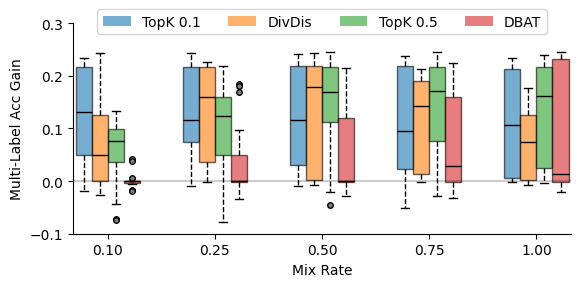

In [60]:
# For average accuracy
fig, ax = plot_aggregate_metrics(
    df=avg_acc_df,
    included_methods=["TopK 0.1", "DivDis", "TopK 0.5", "DBAT"],
    save_path='results_avg.svg',
    metric_col='Accuracy',
    # use_quartiles=False, 
    ylim=(-0.1, 0.3), 
    figsize=(6, 3), 
    width=0.75,
    title="", 
    ylabel="Multi-Label Acc Gain", 
    legend_bbox=(0.5, 1.1)
)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_multi_label_agg.svg", bbox_inches="tight", dpi=300)
plt.show()

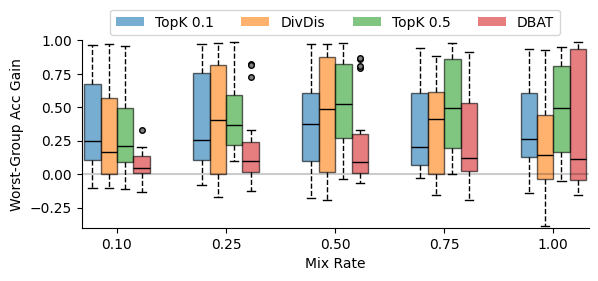

In [76]:
# For average accuracy
fig, ax = plot_aggregate_metrics(
    df=worst_acc_df,
    included_methods=["TopK 0.1", "DivDis", "TopK 0.5", "DBAT"],
    save_path='results_avg.svg',
    metric_col='Accuracy',
    ylim=(-0.4, 1.0), 
    figsize=(6, 3), 
    title="", 
    ylabel="Worst-Group Acc Gain", 
    legend_bbox=(0.5, 1.2)
)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_worst_agg.svg", bbox_inches="tight", dpi=300)
plt.show()

# Mix Rate Scheduling Ablation

In [77]:
ABLATION_METHODS = ["TopK 0.1 Const", "TopK 0.1", "TopK 0.5 Const", "TopK 0.5"]


In [78]:
def create_ablation_df(base_df: pd.DataFrame, schedule_df: pd.DataFrame) -> pd.DataFrame:
    # Get TopK results from constant mix rate
    base_topk_df = base_df[base_df['Method'].isin(['TopK 0.5', 'TopK 0.1'])].copy()
    base_topk_df['Method'] = base_topk_df['Method'].map({
        'TopK 0.5': 'TopK 0.5 Const',
        'TopK 0.1': 'TopK 0.1 Const'
    })
    
    erm_df = base_df[base_df['Method'] == 'ERM'].copy()

    # Get TopK results from scheduled mix rate
    schedule_topk_df = schedule_df[schedule_df['Method'].isin(['TopK 0.5', 'TopK 0.1'])].copy()
    schedule_topk_df['Method'] = schedule_topk_df['Method'].map({
        'TopK 0.5': 'TopK 0.5',
        'TopK 0.1': 'TopK 0.1'
    })

    # Combine the dataframes
    return pd.concat([base_topk_df, schedule_topk_df, erm_df])

# Create ablation dataframes for each metric
ablat_acc_df = create_ablation_df(cc_acc_df, acc_df)
ablat_alt_acc_df = create_ablation_df(cc_alt_acc_df, alt_acc_df)
ablat_worst_acc_df = create_ablation_df(cc_worst_acc_df, worst_acc_df)

# Create averaged accuracy ablation dataframe
avg_acc_ablat_df = pd.DataFrame()
avg_acc_ablat_df['Dataset'] = ablat_acc_df['Dataset']
avg_acc_ablat_df['Method'] = ablat_acc_df['Method']
avg_acc_ablat_df['Mix_Rate'] = ablat_acc_df['Mix_Rate']
avg_acc_ablat_df['Accuracy'] = (ablat_acc_df['Accuracy'] + ablat_alt_acc_df['Accuracy']) / 2

In [79]:
dataset_data = ablat_acc_df[ablat_acc_df['Dataset'] == 'toy_grid']
method_data = dataset_data[dataset_data['Method'] == 'TopK 0.5']
rate_data = method_data.groupby('Mix_Rate')['Accuracy']
rate_data.get_group(0.10)

0    0.988
1    0.676
2    0.790
Name: Accuracy, dtype: float64

In [80]:
method_colors = {
    "TopK 0.1": color_map[0], 
    "DivDis": color_map[1],
    "TopK 0.5": color_map[2], 
    "DBAT": color_map[3], 
    "ERM": color_map[4], 
    "TopK 0.1 Const": '#1e3d8f',
    "TopK 0.5 Const": '#556b2f'
}
method_linestyle = {
    "TopK 0.1": '-',
    "TopK 0.5": '-',
    "TopK 0.1 Const": '--',
    "TopK 0.5 Const": '--'
}


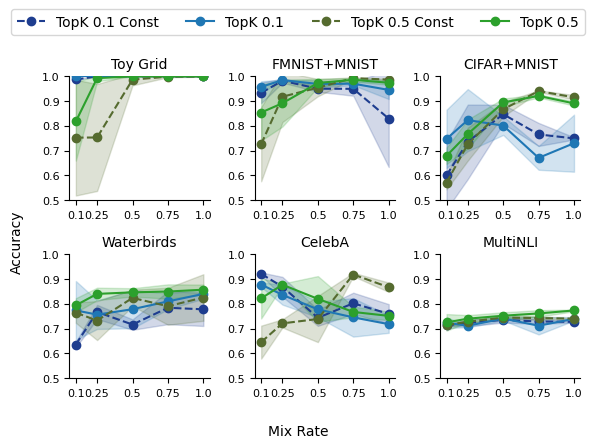

In [81]:
fig, axes = plot_acc_results_grid(
    ablat_acc_df, 
    dataset_titles=DATASET_TITLES, 
    methods=ABLATION_METHODS, 
    method_colors=method_colors,
    method_linestyle=method_linestyle,
    ylim=(0.5, 1.0)
)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_acc_ablat.svg", bbox_inches="tight", dpi=300)
plt.show()

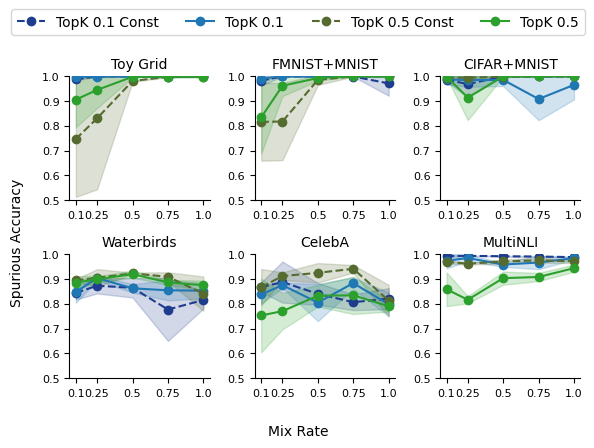

In [82]:
fig, axes = plot_acc_results_grid(
    ablat_alt_acc_df, 
    dataset_titles=DATASET_TITLES, 
    methods=ABLATION_METHODS, 
    method_colors=method_colors,
    method_linestyle=method_linestyle,
    ylim=(0.5, 1.0), 
    ylabel="Spurious Accuracy"
)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_alt_ablat.svg", bbox_inches="tight", dpi=300)
plt.show()

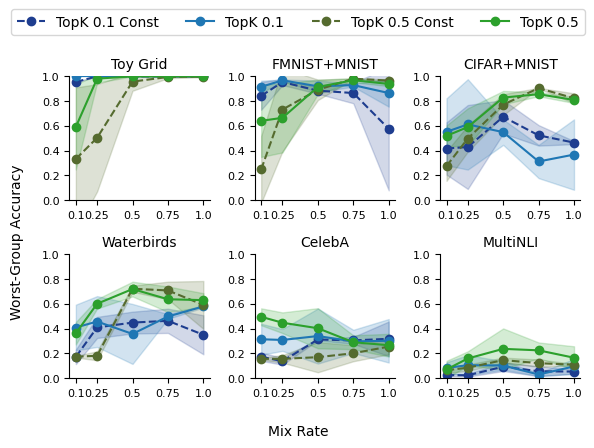

In [83]:
fig, axes = plot_acc_results_grid(
    ablat_worst_acc_df, 
    dataset_titles=DATASET_TITLES, 
    methods=ABLATION_METHODS, 
    method_colors=method_colors,
    method_linestyle=method_linestyle,
    ylim=(0.0, 1.0),
    ylabel="Worst-Group Accuracy"
)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_worst_ablat.svg", bbox_inches="tight", dpi=300)
plt.show()

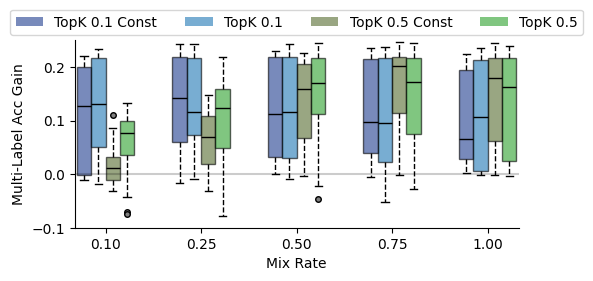

In [87]:
fig, ax = plot_aggregate_metrics(
    df=avg_acc_ablat_df,
    included_methods=ABLATION_METHODS,
    metric_col='Accuracy', 
    ylim=(-0.1, 0.25), 
    ylabel="Multi-Label Acc Gain",
    method_colors=method_colors, 
    legend_bbox=(0.5, 1.2)
)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_multi_label_ablat_agg.svg", bbox_inches="tight", dpi=300)
plt.show()


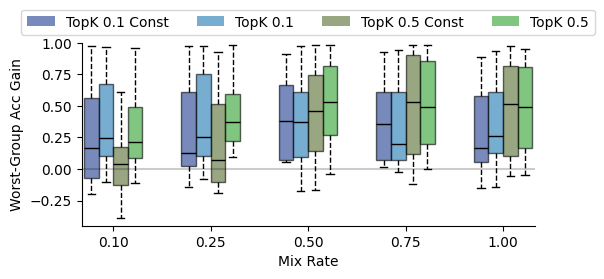

In [95]:
fig, ax = plot_aggregate_metrics(
    df=ablat_worst_acc_df,
    included_methods=ABLATION_METHODS,
    metric_col='Accuracy', 
    ylim=(-0.45, 1.0), 
    ylabel="Worst-Group Acc Gain",
    method_colors=method_colors, 
    legend_bbox=(0.5, 1.22)
)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_worst_ablat_agg.svg", bbox_inches="tight", dpi=300)
plt.show()

looks like scheduling helps a lot when mix rate is over overestimated, and a little when correctly estimated (which makes sense, in some sense sweeping over)

# Marginal Class Frequencies 

In [27]:
# DivDis optimal mix rates (I think no need to add them, don't tell a super coherent story)
class_freqs = {
    "waterbirds": {
        "y0": 0.79, 
        "a0": 0.49
    }, 
    "celebA-0": {
        0.1: {
            "y0": 0.76, 
            "a0": 0.69
        }, 
        0.25: {
            "y0": 0.80, 
            "a0": 0.56
        }, 
        0.5: {
            "y0": 0.86, 
            "a0": 0.38
        }, 
        0.75: {
            "y0": 0.92, 
            "a0": 0.20
        }, 
        1.0: {
            "y0": 0.98, 
            "a0": 0.02
        }
    }, 
    "multi-nli": {
        0.1: {
            "y0": 0.84, 
            "a0": 0.93
        },
        0.25: {
            "y0": 0.71, 
            "a0": 0.93
        },
        0.5: {
            "y0": 0.50, 
            "a0": 0.93,
        }, 
        0.75: {
            "y0": 0.28, 
            "a0": 0.93
        }, 
        1.0: {
            "y0": 0.06, 
            "a0": 0.94
        }
    }
}

def optim_mix_rate(y0_freq, a0_freq):
    prob_01 = y0_freq * (1 - a0_freq) 
    prob_10 = (1 - y0_freq) * a0_freq
    minor_group_prob = prob_01 + prob_10
    return minor_group_prob


for dataset, class_freq in class_freqs.items():
    if isinstance(next(iter(class_freq.values())), dict):
        for mix_rate, freqs in class_freq.items():
            print(dataset, mix_rate, optim_mix_rate(freqs["y0"], freqs["a0"]))
    else:
        print(dataset, optim_mix_rate(class_freq["y0"], class_freq["a0"]))



waterbirds 0.5058
celebA-0 0.1 0.4012
celebA-0 0.25 0.46399999999999997
celebA-0 0.5 0.5864
celebA-0 0.75 0.7520000000000001
celebA-0 1.0 0.9607999999999999
multi-nli 0.1 0.2076
multi-nli 0.25 0.3194
multi-nli 0.5 0.5
multi-nli 0.75 0.6891999999999999
multi-nli 1.0 0.8872
